In [69]:
!git clone https://github.com/HakanAkkurt/AI-for-Self-Driving-Cars

fatal: destination path 'AI-for-Self-Driving-Cars' already exists and is not an empty directory.


In [99]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [106]:
data_directory = '/content/AI-for-Self-Driving-Cars/TrainingsData'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_directory, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_680.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_680.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_680.jpg,0.0,0.0,0,0.000078
1,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_783.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_783.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_783.jpg,0.0,0.0,0,0.000078
2,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_884.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_884.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_884.jpg,0.0,0.0,0,0.000078
3,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_985.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_985.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_985.jpg,0.0,0.0,0,0.000080
4,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_20_086.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_20_086.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_20_086.jpg,0.0,0.0,0,0.000078


In [107]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_09_28_02_03_19_680.jpg,left_2021_09_28_02_03_19_680.jpg,right_2021_09_28_02_03_19_680.jpg,0.0,0.0,0,0.000078
1,center_2021_09_28_02_03_19_783.jpg,left_2021_09_28_02_03_19_783.jpg,right_2021_09_28_02_03_19_783.jpg,0.0,0.0,0,0.000078
2,center_2021_09_28_02_03_19_884.jpg,left_2021_09_28_02_03_19_884.jpg,right_2021_09_28_02_03_19_884.jpg,0.0,0.0,0,0.000078
3,center_2021_09_28_02_03_19_985.jpg,left_2021_09_28_02_03_19_985.jpg,right_2021_09_28_02_03_19_985.jpg,0.0,0.0,0,0.000080
4,center_2021_09_28_02_03_20_086.jpg,left_2021_09_28_02_03_20_086.jpg,right_2021_09_28_02_03_20_086.jpg,0.0,0.0,0,0.000078


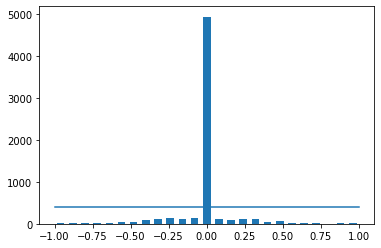

In [108]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6308
removed: 4534
remaining: 1774


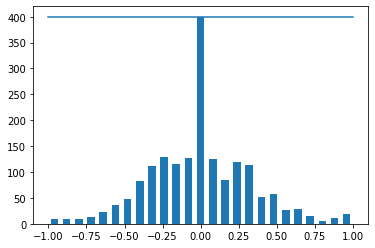

In [109]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [110]:
print(data.iloc[1])
def load_img_steering(data_directory, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_directory, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(data_directory + '/IMG', data)

center      center_2021_09_28_02_03_20_287.jpg
left        left_2021_09_28_02_03_20_287.jpg  
right       right_2021_09_28_02_03_20_287.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.84165e-05                       
Name: 6, dtype: object


In [111]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1419
Valid Samples: 355


Text(0.5, 1.0, 'Validation set')

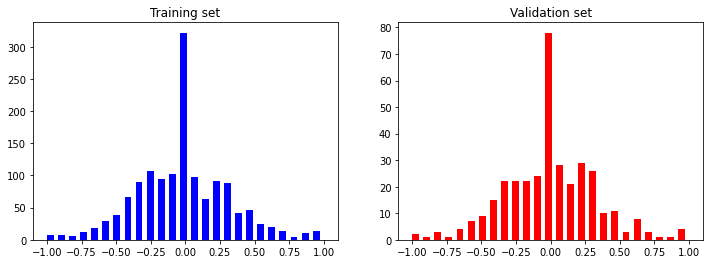

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [113]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

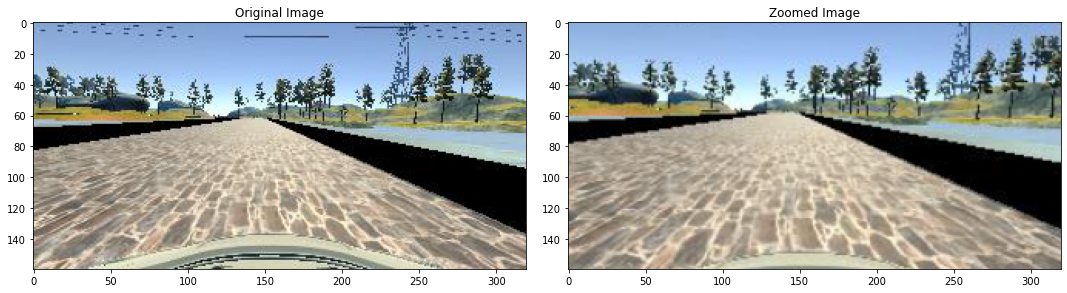

In [114]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [115]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

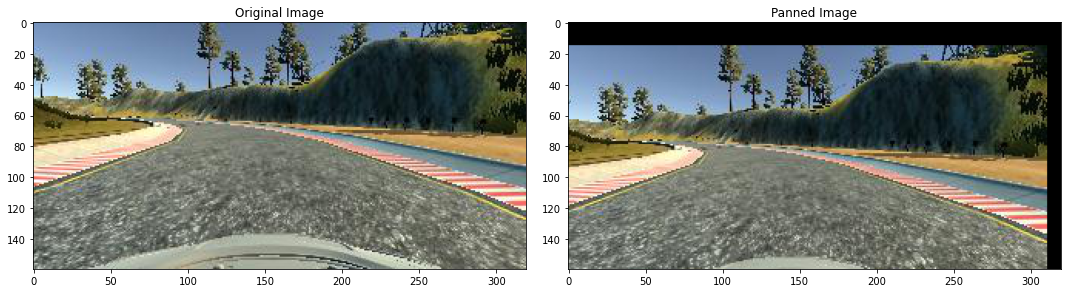

In [116]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [117]:
def img_random_brightness(image):
  brigthness = iaa.Multiply((0.2, 1.2))
  image = brigthness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brigthness Altered Image')

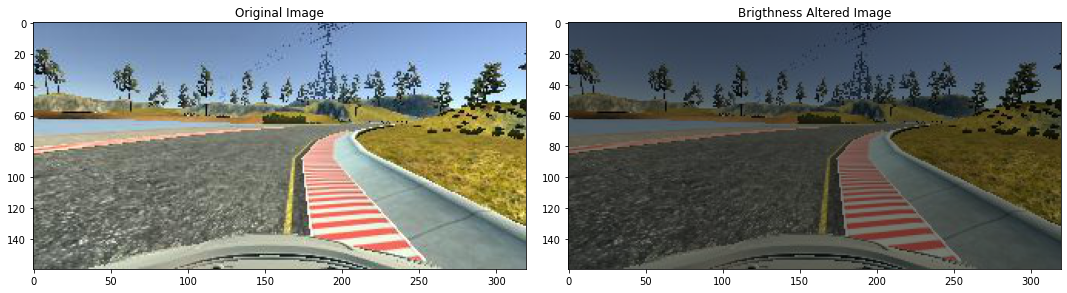

In [118]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brigthness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brigthness_altered_image)
axs[1].set_title('Brigthness Altered Image')

In [119]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: 0.3308802')

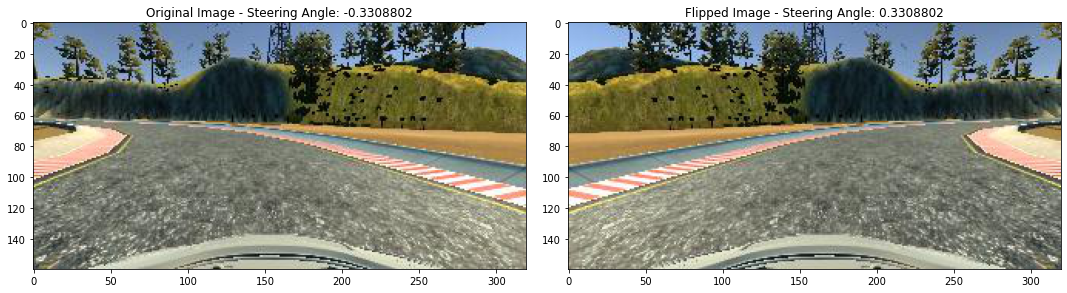

In [120]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle: ' + str(flipped_steering_angle))

In [121]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)

  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  
  return image, steering_angle

In [122]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) -1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

Output hidden; open in https://colab.research.google.com to view.

In [123]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

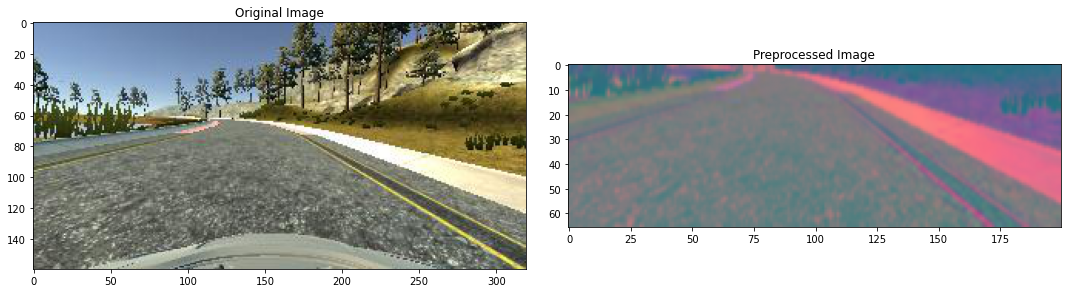

In [124]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [125]:
def batch_generator(image_paths, steering_angle, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) -1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_angle[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Validation Image')

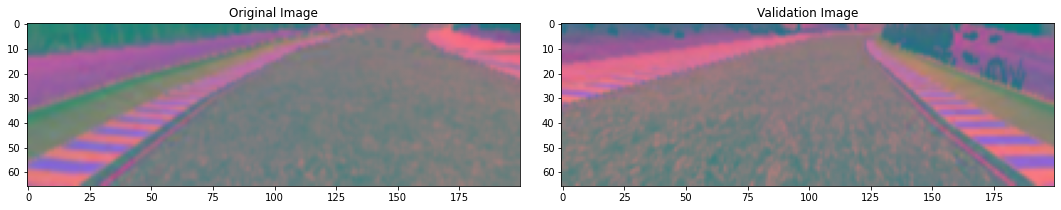

In [126]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Original Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [127]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66, 200, 3),activation='elu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))
 
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
 
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))
 
  optimizer= Adam(learning_rate=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [128]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [129]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)
                             

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 212s 708ms/step - loss: 0.0971 - val_loss: 0.0762
Epoch 2/10
300/300 [==============================] - 220s 736ms/step - loss: 0.0814 - val_loss: 0.0669
Epoch 3/10
300/300 [==============================] - 218s 730ms/step - loss: 0.0758 - val_loss: 0.0824
Epoch 4/10
300/300 [==============================] - 213s 712ms/step - loss: 0.0686 - val_loss: 0.0644
Epoch 5/10
300/300 [==============================] - 213s 713ms/step - loss: 0.0654 - val_loss: 0.0615
Epoch 6/10
300/300 [==============================] - 214s 717ms/step - loss: 0.0623 - val_loss: 0.0583
Epoch 7/10
300/300 [==============================] - 212s 710ms/step - loss: 0.0587 - val_loss: 0.0547
Epoch 8/10
300/300 [==============================] - 218s 730ms/step - loss: 0.0580 - val_loss: 0.0579
Epoch 9/10
300/300 [==============================] - 218s 729ms/step - loss: 0.0558 - val_loss: 0.0535
Epoch 10/10
300/300 [==============================] - 215s 720m

Text(0.5, 0, 'Epoch')

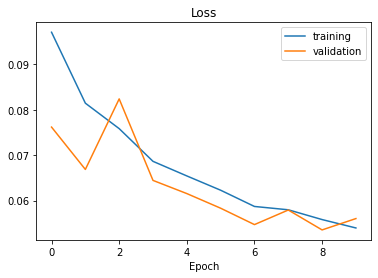

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [131]:
model.save('model.h5')

In [132]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>